In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import argmax
from scipy import constants
import random

import os
import sys
import re
import pdb
import glob

import suftware

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras import metrics
from keras import regularizers
from keras import callbacks
import keras.backend as K

import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
plt.ion()

Using TensorFlow backend.


In [2]:
# Load the energy matrices from Kinney et al. 2010
crp_df = pd.read_csv('../data/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('../data/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
rnap_array = pd.DataFrame.to_numpy(rnap_df)

In [3]:
def mutate_sequence(con_seq, mut_rate):
    bases = ["A","C","G","T"]
    new_seq = list(con_seq)
    to_mutate = np.random.random(size = len(con_seq)) < mut_rate
    for i in range(0,len(to_mutate)):
        if to_mutate[i]:
            new_seq[i] = random.choice([b for b in bases if b not in new_seq[i]])
    return ''.join(new_seq)

# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

# Calculate energy
def get_energy(seq_onehot, matrix_array):
    return np.sum(matrix_array * seq_onehot)

# Calculate boltzmann weight
def get_transcription(energy,mu=2.7):
    tau_max = 1.00
    return tau_max*(np.exp(-(energy-mu))/(1+np.exp(-(energy-mu))))

In [4]:
# Set up parameters
gaps = 7 # Length of gaps between CRP and RNAP binding sites
c_r = 5.94e-3 # Concentration of RNAP; Empirically determined
c_c = 10 ** -1.2 # Concentration of active CRP
e_i = -3.26 # Energy of interaction
t_bg = 0.01 # Background noise
consensus_sequence = "AATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG"
crp_wt_energy = 6.9 # From Kinney et al. 2010
rnap_wt_energy = 8.3 # From Kinney et al. 2010

In [5]:
# Create a single energy matrix
energy_array = np.concatenate((crp_array, np.zeros([gaps,4]), rnap_array))

# Obtain positional information from the parameters given
crp_start = 1
crp_end = crp_start + len(crp_array)
gap_start = crp_end
gap_end = gap_start + gaps
rnap_start = gap_end
rnap_end = rnap_start + len(rnap_array)

In [6]:
#input_data_crp = pd.read_csv('crp-wt/data.txt',delim_whitespace=True)
input_data_full_wt = pd.read_csv('../data/full-wt/data.txt',delim_whitespace=True)

In [7]:
sequences = []
bin_number = []

for _ in range(len(input_data_full_wt)):
    sequences.append(input_data_full_wt['seq'][_])
    bin_number.append(argmax(input_data_full_wt.iloc[_,1:len(input_data_full_wt.columns)].values))

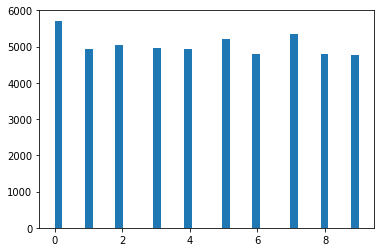

In [8]:
plt.hist(bin_number,bins=40)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sequences, bin_number, test_size=0.2)

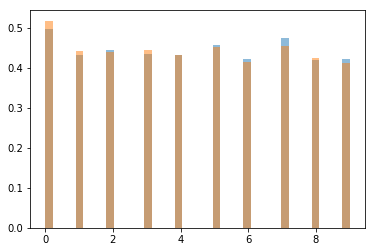

In [10]:
plt.hist(y_train,bins=40,alpha=0.5,density=True)
plt.hist(y_test,bins=40,alpha=0.5,density=True)
plt.show()

In [11]:
#len(X_train[0][1:27]+X_train[0][33:74])

In [12]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [13]:
# convert the crp part of the sequence to one hot encoding
input_seqs_ohe = []
for _ in range(len(X_train)):
    #input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][33:74]))
    input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][34:75]))
    
test_seqs_ohe = []    
for _ in range(len(X_test)):
    #test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][33:74]))
    test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][34:75]))

In [14]:
print(np.shape(input_seqs_ohe))
print(np.shape(test_seqs_ohe))

(40414, 67, 4)
(10104, 67, 4)


In [15]:
# one-hot encoding for y-labels

number_bins = 10

def int_to_onehot(n, n_classes):
    v = [0] * n_classes
    v[n] = 1
    return v

y_train_ohe = []
y_test_ohe = []

for _ in range(len(y_train)):
    y_train_ohe.append(int_to_onehot(y_train[_], number_bins))
    
for _ in range(len(y_test)):
    y_test_ohe.append(int_to_onehot(y_test[_], number_bins))    

In [16]:
np.shape(y_train_ohe[1])[0]

10

In [17]:
number_input_layer_nodes = len(input_seqs_ohe[0])*4 +1   
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

In [18]:
#import tensorflow as tf
from keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  


    def call(self, inputs):
        #print(self.connections)
        
        kernel_times_connections = multiply([self.kernel, self.connections])
        #output = K.dot(inputs, self.kernel * self.connections)
        
        # for implementing custom constraint, print out kernel. Set last two elements equal to each other.
        output = K.dot(inputs,kernel_times_connections)

        #print('outputs: ',output)
        #print('inputs: ',inputs)
        #print('kernel',self.kernel)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    

In [19]:
#from tensorflow.keras import layers
from keras import layers
import tensorflow as tf


class CustomSoftmax(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        super(CustomSoftmax, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)

    def call(self, inputs):
        
        #return K.dot(inputs, self.w) + self.b
        #return K.dot(self.w,inputs) + self.b
        #return tf.matmul(inputs, self.w) + self.b
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b) 
        print('output:',output)
        return output

In [20]:
# this layer keeps weights non-trainable and biases traianable 
class CustomSoftmax2(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.units = units
        super(CustomSoftmax2, self).__init__()
        
    
    def build(self, input_shape): 
        
        self.w = self.add_weight(shape=(self.input_dim, self.units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)
        
        super(CustomSoftmax2, self).build(input_shape)    

    def call(self, inputs):
        
        #return K.dot(inputs, self.w) + self.b
        #return K.dot(self.w,inputs) + self.b
        #return tf.matmul(inputs, self.w) + self.b
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b) 
        print('output:',output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [21]:
# this layer keeps weights non-trainable and biases traianable 
# with the first 3 values of the bias fixed to 0 so that the last
# trainable value represents interactions energy

from keras.layers import multiply
class CustomSoftmax3(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.units = units
        super(CustomSoftmax3, self).__init__()
        
    
    def build(self, input_shape): 
        
        self.w = self.add_weight(shape=(self.input_dim, self.units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)
        
        super(CustomSoftmax3, self).build(input_shape)    

    def call(self, inputs):
        

        #output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b)
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + multiply([self.b,tf.constant([0.0,0.0,0.0,1.0])])) 
        print('input',inputs)
        print('weight: ',self.w)
        print('input*weight',tf.matmul(inputs, self.w))
        print('output:',output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [22]:
# define two groups which represent binding sites for the two proteins crp and rnap

group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)
group3 = Lambda(lambda x: x[:,268:269], output_shape=((1,)))(inputTensor)


# From input to first hidden layer. The groups are connected to two nodes
# node group1 represents energy of crp and group2 represents rnap energy.

# rename group1 to crp pwm

group1 = Dense(1,use_bias=False,name='CRP_pwm')(group1)
group2 = Dense(1,use_bias=False,name='RNAP_pwm')(group2)
group3 = Dense(1,use_bias=False,name='one-feature')(group3)

#group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# the groups from the previous layer have to be concatenated so
concatenateLayer = Concatenate()([group1,group2,group3])

# gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
# concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# softmax layer needs to have multiple inputs

# try custom connections in the trainable softmax
#softmaxLayer = Dense(4,activation='softmax', trainable=True, use_bias=True,name='softmax_layer')(concatenateLayer)
#softmaxLayer = CustomSoftmax(4,2)(concatenateLayer)
#softmaxLayer = CustomSoftmax2(4,input_dim= 2,output_dim=4)(concatenateLayer)
#softmaxLayer = CustomSoftmax3(4,input_dim= 2,output_dim=4)(concatenateLayer)
softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(concatenateLayer)

# tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(tauTensor)

tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
intermediateTensor = Dense(10,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate')(tauTensor)
outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(intermediateTensor)


#create the model:
model = Model(inputTensor,outputTensor)
# model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)



In [23]:
# # old model
# # define two groups which represent binding sites for the two proteins crp and rnap

# group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
# group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)


# # From input to first hidden layer. The groups are connected to two nodes
# # node group1 represents energy of crp and group2 represents rnap energy.

# # rename group1 to crp pwm

# group1 = Dense(1,use_bias=False,name='CRP_pwm')(group1)
# group2 = Dense(1,use_bias=False,name='RNAP_pwm')(group2)

# #group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# # the groups from the previous layer have to be concatenated so
# concatenateLayer = Concatenate()([group1,group2])

# # gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
# # concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# # softmax layer needs to have multiple inputs

# # try custom connections in the trainable softmax
# #softmaxLayer = Dense(4,activation='softmax', trainable=True, use_bias=True,name='softmax_layer')(concatenateLayer)
# #softmaxLayer = CustomSoftmax(4,2)(concatenateLayer)
# #softmaxLayer = CustomSoftmax2(4,input_dim= 2,output_dim=4)(concatenateLayer)
# softmaxLayer = CustomSoftmax3(4,input_dim= 2,output_dim=4)(concatenateLayer)
# #softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=True,name='softmax_layer')(concatenateLayer_with_gamma)

# # tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# # outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(tauTensor)

# tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# intermediateTensor = Dense(10,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate')(tauTensor)
# outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(intermediateTensor)


# #create the model:
# model = Model(inputTensor,outputTensor)
# # model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)



In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence (InputLayer)           (None, 269)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 104)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 164)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           Sequence[0][0]                   
__________________________________________________________________________________________________
CRP_pwm (D

In [25]:
model.layers

In [26]:
print(np.shape(model.layers[4].get_weights()))
print(np.shape(model.layers[5].get_weights()))
print(np.shape(model.layers[6].get_weights()))

(1, 104, 1)
(1, 164, 1)
(1, 1, 1)


In [27]:
print(model.layers[6].get_weights())

[array([[-0.30285156]], dtype=float32)]


### Set initial weights for last layer...
...so that only the last two states (S3 and S4 in write-up) contribute to transcription

In [28]:
tau_layer_weights = model.layers[9].get_weights()[0].copy()
tau_layer_weights.shape

(4, 1)

In [29]:
tau_layer_initial_weights = np.array([0,0,1,1])
tau_layer_initial_weights = tau_layer_initial_weights.reshape(4,1)
model.layers[9].set_weights([tau_layer_initial_weights])
model.layers[9].get_weights()[0]

array([[0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

### The following show non-trainable and trainable weights in the softmax layer

In [30]:
# these weights appear to be in reverse order. 
print(model.layers[8].get_weights())


[array([[ 0.66718316, -0.3811981 , -0.24688268, -0.61511344],
       [-0.63823235, -0.83144784, -0.08689785, -0.40278357],
       [ 0.37204456, -0.44292933, -0.8662934 , -0.6896068 ]],
      dtype=float32)]


### Set softmax layer weights manually, will be kept frozen during training
Note that the bias weights here may be interpreted as gamma

In [31]:
# the following are the input weights to the softmax array.
# the first two arrays indicate 4 weights each coming out of the e_c and 
# e_r nodes. The last node indicates the gamma input, connecting only to
# microstate 4.

#softmax_weights = np.array([[0,1,0,1],[0,0,1,1]]) # this works
softmax_weights = np.array([[0,1,0,1],[0,0,1,1],[0,0,0,1]]) # this works
#softmax_weights = np.array([[0,0,1,1],[0,1,0,1]])
#softmax_biases = np.array([0,0,0,1])

# keras' set_weights expects weights and bias in a list
#softmax_weights = [softmax_biases,softmax_weights]

# without bias
softmax_weights = [softmax_weights]

# set weights
model.layers[8].set_weights(softmax_weights)
# see set weights
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

## Compile model

In [32]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0005), metrics=['mean_absolute_error'])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['mean_absolute_error'])

In [33]:
np.array(X_train).shape[0]

40414

In [34]:
np.shape(input_seqs_ohe[_].flatten())
temp = input_seqs_ohe[0].flatten()
temp = np.append(temp,1)
temp.shape

(269,)

In [35]:
input_sequences_tensor2 = []
test_input_sequences_tensor2 = []

for _ in range(len(input_seqs_ohe)):
    temp = input_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    #input_seqs_ohe[_] = np.append(input_seqs_ohe[_],1)
    input_sequences_tensor2.append(temp)
    
for _ in range(len(test_seqs_ohe)):
    
    temp = test_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    test_input_sequences_tensor2.append(temp)

In [36]:
input_sequences_tensor2 = np.array(input_sequences_tensor2)
test_input_sequences_tensor2 = np.array(test_input_sequences_tensor2)

In [37]:
input_sequences_tensor2[0].shape

(269,)

In [38]:
# input_seqs_ohe = np.array(input_seqs_ohe)
# input_sequences_tensor = input_seqs_ohe.reshape(-1,len(input_seqs_ohe[0])*4+1)

# test_seqs_ohe = np.array(test_seqs_ohe)
# test_input_sequences_tensor = test_seqs_ohe.reshape(-1,len(test_seqs_ohe[0])*4+1)

labels = np.array(y_train_ohe)
test_labels = np.array(y_test_ohe)

In [39]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [40]:
#model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.00001), metrics=['categorical_accuracy'])
model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.0001), metrics=['categorical_accuracy'])

In [41]:
# history = model.fit([input_sequences_tensor,gamma_input_list], labels, 
#                     validation_split=0.1, epochs=100,verbose=1,callbacks=[esCallBack,tbCallBack])  

history = model.fit(input_sequences_tensor2, labels, validation_split=0.2, epochs=1500,verbose=1)

Train on 32331 samples, validate on 8083 samples
Epoch 1/1500
32331/32331 [==============================] - 1s 38us/step - loss: 1.0952 - categorical_accuracy: 0.0939 - val_loss: 1.0952 - val_categorical_accuracy: 0.0985
Epoch 2/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0952 - categorical_accuracy: 0.1018 - val_loss: 1.0952 - val_categorical_accuracy: 0.1115
Epoch 3/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0952 - categorical_accuracy: 0.1126 - val_loss: 1.0952 - val_categorical_accuracy: 0.1106
Epoch 4/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0952 - categorical_accuracy: 0.1127 - val_loss: 1.0952 - val_categorical_accuracy: 0.1106
Epoch 5/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0952 - categorical_accuracy: 0.1127 - val_loss: 1.0952 - val_categorical_accuracy: 0.1106
Epoch 6/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.095

Epoch 48/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0921 - categorical_accuracy: 0.2268 - val_loss: 1.0920 - val_categorical_accuracy: 0.2278
Epoch 49/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0921 - categorical_accuracy: 0.2278 - val_loss: 1.0920 - val_categorical_accuracy: 0.2295
Epoch 50/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0921 - categorical_accuracy: 0.2297 - val_loss: 1.0919 - val_categorical_accuracy: 0.2323
Epoch 51/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0920 - categorical_accuracy: 0.2307 - val_loss: 1.0919 - val_categorical_accuracy: 0.2338
Epoch 52/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0920 - categorical_accuracy: 0.2314 - val_loss: 1.0919 - val_categorical_accuracy: 0.2389
Epoch 53/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0920 - categorical_accuracy: 0.2340 - val_loss

Epoch 95/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0911 - categorical_accuracy: 0.2709 - val_loss: 1.0910 - val_categorical_accuracy: 0.2827
Epoch 96/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0911 - categorical_accuracy: 0.2719 - val_loss: 1.0910 - val_categorical_accuracy: 0.2827
Epoch 97/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0911 - categorical_accuracy: 0.2726 - val_loss: 1.0910 - val_categorical_accuracy: 0.2829
Epoch 98/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0911 - categorical_accuracy: 0.2732 - val_loss: 1.0909 - val_categorical_accuracy: 0.2842
Epoch 99/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0911 - categorical_accuracy: 0.2739 - val_loss: 1.0909 - val_categorical_accuracy: 0.2841
Epoch 100/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0911 - categorical_accuracy: 0.2738 - val_los

Epoch 142/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0908 - categorical_accuracy: 0.2843 - val_loss: 1.0906 - val_categorical_accuracy: 0.2901
Epoch 143/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0908 - categorical_accuracy: 0.2839 - val_loss: 1.0906 - val_categorical_accuracy: 0.2902
Epoch 144/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0908 - categorical_accuracy: 0.2838 - val_loss: 1.0906 - val_categorical_accuracy: 0.2925
Epoch 145/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0908 - categorical_accuracy: 0.2844 - val_loss: 1.0906 - val_categorical_accuracy: 0.2911
Epoch 146/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0908 - categorical_accuracy: 0.2839 - val_loss: 1.0906 - val_categorical_accuracy: 0.2937
Epoch 147/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0908 - categorical_accuracy: 0.2846 - va

Epoch 189/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0906 - categorical_accuracy: 0.2891 - val_loss: 1.0905 - val_categorical_accuracy: 0.2999
Epoch 190/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0906 - categorical_accuracy: 0.2890 - val_loss: 1.0905 - val_categorical_accuracy: 0.2953
Epoch 191/1500
32331/32331 [==============================] - 1s 34us/step - loss: 1.0906 - categorical_accuracy: 0.2895 - val_loss: 1.0905 - val_categorical_accuracy: 0.2967
Epoch 192/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0906 - categorical_accuracy: 0.2903 - val_loss: 1.0904 - val_categorical_accuracy: 0.2962
Epoch 193/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0906 - categorical_accuracy: 0.2895 - val_loss: 1.0904 - val_categorical_accuracy: 0.2948
Epoch 194/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0906 - categorical_accuracy: 0.2894 - va

Epoch 236/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2919 - val_loss: 1.0904 - val_categorical_accuracy: 0.3000
Epoch 237/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2932 - val_loss: 1.0904 - val_categorical_accuracy: 0.2972
Epoch 238/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0905 - categorical_accuracy: 0.2913 - val_loss: 1.0904 - val_categorical_accuracy: 0.2994
Epoch 239/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0905 - categorical_accuracy: 0.2925 - val_loss: 1.0903 - val_categorical_accuracy: 0.2978
Epoch 240/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0905 - categorical_accuracy: 0.2926 - val_loss: 1.0904 - val_categorical_accuracy: 0.2938
Epoch 241/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2922 - va

Epoch 283/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2942 - val_loss: 1.0903 - val_categorical_accuracy: 0.2983
Epoch 284/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2942 - val_loss: 1.0903 - val_categorical_accuracy: 0.3014
Epoch 285/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2946 - val_loss: 1.0903 - val_categorical_accuracy: 0.2990
Epoch 286/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2942 - val_loss: 1.0903 - val_categorical_accuracy: 0.3011
Epoch 287/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2947 - val_loss: 1.0903 - val_categorical_accuracy: 0.2993
Epoch 288/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2943 - va

Epoch 330/1500
32331/32331 [==============================] - 1s 28us/step - loss: 1.0904 - categorical_accuracy: 0.2957 - val_loss: 1.0902 - val_categorical_accuracy: 0.2979
Epoch 331/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2958 - val_loss: 1.0902 - val_categorical_accuracy: 0.3014
Epoch 332/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2955 - val_loss: 1.0902 - val_categorical_accuracy: 0.3010
Epoch 333/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2961 - val_loss: 1.0902 - val_categorical_accuracy: 0.2982
Epoch 334/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2958 - val_loss: 1.0902 - val_categorical_accuracy: 0.2998
Epoch 335/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2955 - va

Epoch 377/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0904 - categorical_accuracy: 0.2967 - val_loss: 1.0902 - val_categorical_accuracy: 0.2999
Epoch 378/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0904 - categorical_accuracy: 0.2975 - val_loss: 1.0902 - val_categorical_accuracy: 0.3014
Epoch 379/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2976 - val_loss: 1.0902 - val_categorical_accuracy: 0.2998
Epoch 380/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0904 - categorical_accuracy: 0.2972 - val_loss: 1.0902 - val_categorical_accuracy: 0.3000
Epoch 381/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0904 - categorical_accuracy: 0.2969 - val_loss: 1.0902 - val_categorical_accuracy: 0.2999
Epoch 382/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0904 - categorical_accuracy: 0.2973 - va

Epoch 424/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2976 - val_loss: 1.0902 - val_categorical_accuracy: 0.3009
Epoch 425/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0903 - categorical_accuracy: 0.2982 - val_loss: 1.0901 - val_categorical_accuracy: 0.3008
Epoch 426/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2977 - val_loss: 1.0902 - val_categorical_accuracy: 0.3005
Epoch 427/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2983 - val_loss: 1.0901 - val_categorical_accuracy: 0.2998
Epoch 428/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2979 - val_loss: 1.0901 - val_categorical_accuracy: 0.3005
Epoch 429/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2983 - va

Epoch 471/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2975 - val_loss: 1.0901 - val_categorical_accuracy: 0.2994
Epoch 472/1500
32331/32331 [==============================] - 1s 28us/step - loss: 1.0903 - categorical_accuracy: 0.2988 - val_loss: 1.0901 - val_categorical_accuracy: 0.3005
Epoch 473/1500
32331/32331 [==============================] - 1s 27us/step - loss: 1.0903 - categorical_accuracy: 0.2981 - val_loss: 1.0901 - val_categorical_accuracy: 0.3003
Epoch 474/1500
32331/32331 [==============================] - 1s 27us/step - loss: 1.0903 - categorical_accuracy: 0.2985 - val_loss: 1.0901 - val_categorical_accuracy: 0.2999
Epoch 475/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2981 - val_loss: 1.0901 - val_categorical_accuracy: 0.3010
Epoch 476/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0903 - categorical_accuracy: 0.2984 - va

Epoch 518/1500
32331/32331 [==============================] - 1s 27us/step - loss: 1.0903 - categorical_accuracy: 0.2994 - val_loss: 1.0901 - val_categorical_accuracy: 0.3019
Epoch 519/1500
32331/32331 [==============================] - 1s 26us/step - loss: 1.0903 - categorical_accuracy: 0.2985 - val_loss: 1.0901 - val_categorical_accuracy: 0.2998
Epoch 520/1500
32331/32331 [==============================] - 1s 27us/step - loss: 1.0903 - categorical_accuracy: 0.2983 - val_loss: 1.0901 - val_categorical_accuracy: 0.3001
Epoch 521/1500
32331/32331 [==============================] - 1s 26us/step - loss: 1.0903 - categorical_accuracy: 0.2989 - val_loss: 1.0901 - val_categorical_accuracy: 0.3004
Epoch 522/1500
32331/32331 [==============================] - 1s 26us/step - loss: 1.0903 - categorical_accuracy: 0.3000 - val_loss: 1.0901 - val_categorical_accuracy: 0.3003
Epoch 523/1500
32331/32331 [==============================] - 1s 26us/step - loss: 1.0903 - categorical_accuracy: 0.2991 - va

Epoch 565/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0903 - categorical_accuracy: 0.2993 - val_loss: 1.0901 - val_categorical_accuracy: 0.3019
Epoch 566/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0903 - categorical_accuracy: 0.2988 - val_loss: 1.0901 - val_categorical_accuracy: 0.3010
Epoch 567/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0903 - categorical_accuracy: 0.2993 - val_loss: 1.0901 - val_categorical_accuracy: 0.2996
Epoch 568/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2998 - val_loss: 1.0901 - val_categorical_accuracy: 0.3026
Epoch 569/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0903 - categorical_accuracy: 0.2990 - val_loss: 1.0901 - val_categorical_accuracy: 0.3020
Epoch 570/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.3004 - va

Epoch 612/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2995 - val_loss: 1.0901 - val_categorical_accuracy: 0.3020
Epoch 613/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.3005 - val_loss: 1.0901 - val_categorical_accuracy: 0.3010
Epoch 614/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2992 - val_loss: 1.0901 - val_categorical_accuracy: 0.3008
Epoch 615/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0903 - categorical_accuracy: 0.2997 - val_loss: 1.0901 - val_categorical_accuracy: 0.2998
Epoch 616/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0903 - categorical_accuracy: 0.2998 - val_loss: 1.0901 - val_categorical_accuracy: 0.2994
Epoch 617/1500
32331/32331 [==============================] - 1s 36us/step - loss: 1.0903 - categorical_accuracy: 0.2998 - va

Epoch 659/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3000
Epoch 660/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 - val_categorical_accuracy: 0.3003
Epoch 661/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.2995 - val_loss: 1.0901 - val_categorical_accuracy: 0.3031
Epoch 662/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3001 - val_loss: 1.0900 - val_categorical_accuracy: 0.3004
Epoch 663/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3002 - val_loss: 1.0900 - val_categorical_accuracy: 0.3020
Epoch 664/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3007 - va

32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3002 - val_loss: 1.0900 - val_categorical_accuracy: 0.2998
Epoch 706/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.2993
Epoch 707/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3007 - val_loss: 1.0900 - val_categorical_accuracy: 0.3034
Epoch 708/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.0900 - val_categorical_accuracy: 0.2999
Epoch 709/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3031
Epoch 710/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 

32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3000 - val_loss: 1.0900 - val_categorical_accuracy: 0.3041
Epoch 752/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3009 - val_loss: 1.0900 - val_categorical_accuracy: 0.3015
Epoch 753/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3007 - val_loss: 1.0900 - val_categorical_accuracy: 0.3014
Epoch 754/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.2998 - val_loss: 1.0900 - val_categorical_accuracy: 0.3011
Epoch 755/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 756/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.2996 - val_loss: 1.0900 

Epoch 798/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3004 - val_loss: 1.0900 - val_categorical_accuracy: 0.3026
Epoch 799/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 - val_categorical_accuracy: 0.3029
Epoch 800/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 - val_categorical_accuracy: 0.3026
Epoch 801/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3006
Epoch 802/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3000 - val_loss: 1.0900 - val_categorical_accuracy: 0.3027
Epoch 803/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - va

Epoch 845/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3000 - val_loss: 1.0900 - val_categorical_accuracy: 0.3017
Epoch 846/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 - val_categorical_accuracy: 0.3001
Epoch 847/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 - val_categorical_accuracy: 0.3016
Epoch 848/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3004
Epoch 849/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.0900 - val_categorical_accuracy: 0.3017
Epoch 850/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - va

Epoch 892/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3000 - val_loss: 1.0900 - val_categorical_accuracy: 0.3005
Epoch 893/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3015
Epoch 894/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3009 - val_loss: 1.0900 - val_categorical_accuracy: 0.3001
Epoch 895/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3035
Epoch 896/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3021 - val_loss: 1.0900 - val_categorical_accuracy: 0.3037
Epoch 897/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3000 - va

Epoch 939/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.0900 - val_categorical_accuracy: 0.3015
Epoch 940/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3005
Epoch 941/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3001 - val_loss: 1.0900 - val_categorical_accuracy: 0.3026
Epoch 942/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.0900 - val_categorical_accuracy: 0.3030
Epoch 943/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3019 - val_loss: 1.0900 - val_categorical_accuracy: 0.2996
Epoch 944/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - va

Epoch 986/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3008
Epoch 987/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.0900 - val_categorical_accuracy: 0.3020
Epoch 988/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3009 - val_loss: 1.0900 - val_categorical_accuracy: 0.3005
Epoch 989/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3004 - val_loss: 1.0900 - val_categorical_accuracy: 0.3014
Epoch 990/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3013 - val_loss: 1.0900 - val_categorical_accuracy: 0.3038
Epoch 991/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3003 - va

32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3031
Epoch 1033/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3009
Epoch 1034/1500
32331/32331 [==============================] - 1s 38us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 1035/1500
32331/32331 [==============================] - 1s 35us/step - loss: 1.0902 - categorical_accuracy: 0.3019 - val_loss: 1.0900 - val_categorical_accuracy: 0.3008
Epoch 1036/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3024
Epoch 1037/1500
32331/32331 [==============================] - 1s 36us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.

32331/32331 [==============================] - 1s 28us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0900 - val_categorical_accuracy: 0.3026
Epoch 1079/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3009 - val_loss: 1.0900 - val_categorical_accuracy: 0.3001
Epoch 1080/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3010
Epoch 1081/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3032
Epoch 1082/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 1083/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.

32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.0900 - val_categorical_accuracy: 0.3009
Epoch 1125/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0900 - val_categorical_accuracy: 0.3010
Epoch 1126/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3034
Epoch 1127/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.0900 - val_categorical_accuracy: 0.3031
Epoch 1128/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0900 - val_categorical_accuracy: 0.3009
Epoch 1129/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3009 - val_loss: 1.

32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3034
Epoch 1171/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.0900 - val_categorical_accuracy: 0.3014
Epoch 1172/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.2998
Epoch 1173/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3018 - val_loss: 1.0900 - val_categorical_accuracy: 0.3026
Epoch 1174/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3015
Epoch 1175/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.

32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3016
Epoch 1217/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3001
Epoch 1218/1500
32331/32331 [==============================] - 1s 35us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3040
Epoch 1219/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3021 - val_loss: 1.0900 - val_categorical_accuracy: 0.3032
Epoch 1220/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.0900 - val_categorical_accuracy: 0.3016
Epoch 1221/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.

32331/32331 [==============================] - 1s 34us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 1263/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3020
Epoch 1264/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.0900 - val_categorical_accuracy: 0.3034
Epoch 1265/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3017
Epoch 1266/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3009 - val_loss: 1.0900 - val_categorical_accuracy: 0.3014
Epoch 1267/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.

32331/32331 [==============================] - 1s 33us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0900 - val_categorical_accuracy: 0.3027
Epoch 1309/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0900 - val_categorical_accuracy: 0.3037
Epoch 1310/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0900 - val_categorical_accuracy: 0.3027
Epoch 1311/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.0900 - val_categorical_accuracy: 0.3035
Epoch 1312/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3035
Epoch 1313/1500
32331/32331 [==============================] - 1s 33us/step - loss: 1.0902 - categorical_accuracy: 0.3013 - val_loss: 1.

32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 1355/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0900 - val_categorical_accuracy: 0.3040
Epoch 1356/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3051
Epoch 1357/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3023 - val_loss: 1.0900 - val_categorical_accuracy: 0.3034
Epoch 1358/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0900 - val_categorical_accuracy: 0.3004
Epoch 1359/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.

32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3010
Epoch 1401/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3018 - val_loss: 1.0900 - val_categorical_accuracy: 0.3008
Epoch 1402/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0900 - val_categorical_accuracy: 0.3011
Epoch 1403/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3018 - val_loss: 1.0900 - val_categorical_accuracy: 0.3042
Epoch 1404/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3042
Epoch 1405/1500
32331/32331 [==============================] - 1s 34us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.

32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 1447/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.0900 - val_categorical_accuracy: 0.3004
Epoch 1448/1500
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.0900 - val_categorical_accuracy: 0.3008
Epoch 1449/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3040
Epoch 1450/1500
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3023 - val_loss: 1.0900 - val_categorical_accuracy: 0.2999
Epoch 1451/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.

32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3012 - val_loss: 1.0900 - val_categorical_accuracy: 0.3029
Epoch 1493/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.0900 - val_categorical_accuracy: 0.3036
Epoch 1494/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3010 - val_loss: 1.0900 - val_categorical_accuracy: 0.3024
Epoch 1495/1500
32331/32331 [==============================] - 1s 30us/step - loss: 1.0902 - categorical_accuracy: 0.3018 - val_loss: 1.0900 - val_categorical_accuracy: 0.3040
Epoch 1496/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0900 - val_categorical_accuracy: 0.3030
Epoch 1497/1500
32331/32331 [==============================] - 1s 29us/step - loss: 1.0902 - categorical_accuracy: 0.3022 - val_loss: 1.

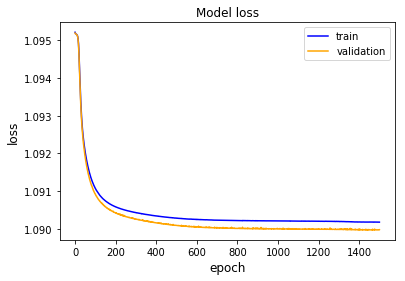

In [42]:
# plot losses

plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

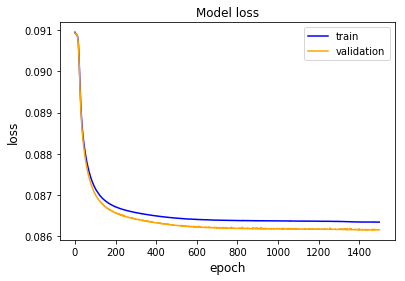

In [43]:
# plot losses

plt.figure()
plt.plot(np.log(history.history['loss']),color='blue')
plt.plot(np.log(history.history['val_loss']),color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

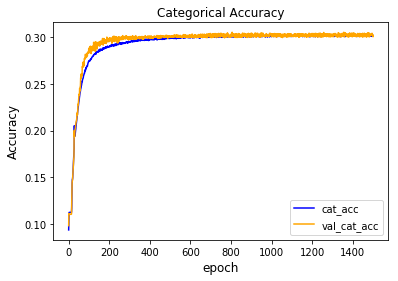

In [44]:
plt.figure()
plt.plot(history.history['categorical_accuracy'],color='blue')
plt.plot(history.history['val_categorical_accuracy'],color='orange')
plt.title('Categorical Accuracy',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['cat_acc', 'val_cat_acc'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [45]:
# predictions_on_test = model.predict(test_input_sequences_tensor)
predictions_on_test = model.predict(test_input_sequences_tensor2)

In [46]:
model.evaluate(test_input_sequences_tensor2,test_labels)

10104/10104 [==============================] - 0s 12us/step


[1.090324879636485, 0.2962193190579554]

### First hidden layer weights (PWMs)

Need to input sequence corresponding to CRPs binding site. i.e. fixed the shape of test_input_sequences_tensor

In [47]:
crp_weights = model.layers[4].get_weights()[0].copy()
rnap_weights = model.layers[5].get_weights()[0].copy()

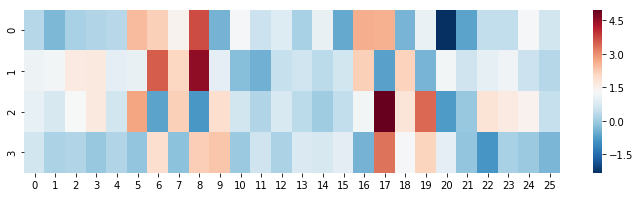

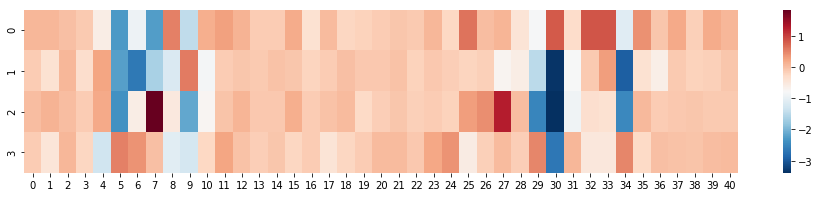

In [48]:
crp_weights = crp_weights.reshape(26,4)
rnap_weights = rnap_weights.reshape(41,4)


plt.figure(figsize=(12,3))
sns.heatmap(crp_weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(16,3))
sns.heatmap(rnap_weights.T,cmap='RdBu_r')
#sns.heatmap(rnap_weights.T,cmap='RdBu_r')
plt.show()

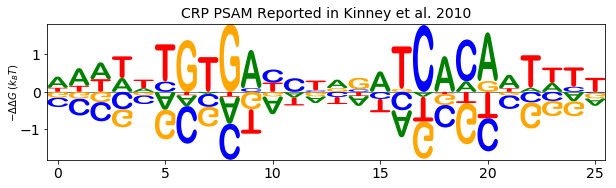

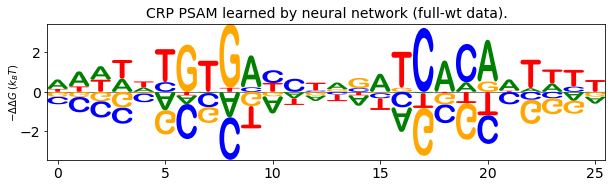

In [73]:
import logomaker
crp_logo_df = pd.DataFrame(crp_weights,columns=['A','C','G','T'])

crp_df.columns = ['A','C','G','T']
logomaker.Logo(-crp_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('CRP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(-crp_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('CRP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)

plt.show()
#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

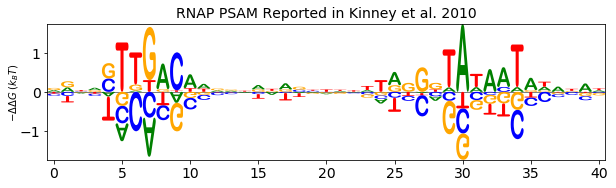

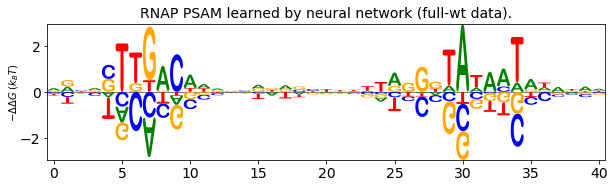

In [75]:
rnap_logo_df = pd.DataFrame(rnap_weights,columns=['A','C','G','T'])
rnap_df.columns = ['A','C','G','T']
logomaker.Logo(-rnap_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
plt.tick_params(labelsize=14)

In [51]:
model.layers[6].get_weights()

[array([[-4.3217354]], dtype=float32)]

In [52]:
e_i_model = Model(inputs=model.input,outputs=model.layers[6].output)
e_i_node_output = e_i_model.predict([test_input_sequences_tensor2])

In [53]:
np.mean(e_i_node_output)

-4.3217354

In [54]:
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

In [55]:
model.layers[9].get_weights()

[array([[0.       ],
        [0.       ],
        [3.880636 ],
        [3.7853699]], dtype=float32)]

### MI estimation

In [56]:
tau_layer_model = Model(inputs=model.input,outputs=model.layers[9].output)
tau_output = tau_layer_model.predict(test_input_sequences_tensor2)


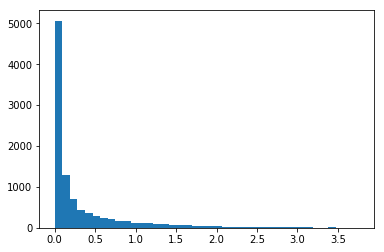

In [57]:
plt.hist(tau_output,bins=40)
plt.show()

In [58]:
# estimate probability density at each of the output bins using deft. 
import suftware

In [59]:
softmax_bin_layer_model = Model(inputs=model.input,outputs=model.layers[11].output)
softmax_bin_out = softmax_bin_layer_model.predict(test_input_sequences_tensor2)


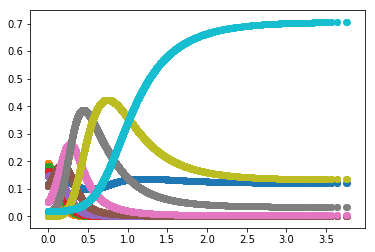

In [60]:
for _ in range(10):
    plt.scatter(tau_output,softmax_bin_out[:,_])
plt.show()

In [63]:
# y_test -> bin number
# tau_output -> tau
# find p(tau|bin)

total_bins = 10

function_dict = {}

tau_given_bin = {}
for b in range(total_bins):
    temp_tau_given_bin_n = []
    for _ in range(len(y_test)):
        if(y_test[_]==b):
            temp_tau_given_bin_n.append(tau_output[_])
    tau_given_bin[str(b)]= np.array(temp_tau_given_bin_n).flatten()  
    Q_star = suftware.DensityEstimator(np.array(temp_tau_given_bin_n).flatten(),alpha=2).density_func
    print(b)
    function_dict[str(b)] = Q_star

0
1
2
3
4
5
6
7
8
9


In [64]:
tau_given_bin['6']

array([2.31779560e-01, 1.47295699e-01, 1.97336212e-01, 1.76746428e-01,
       3.39482427e-02, 2.48078689e-01, 2.69454241e-01, 9.24175531e-02,
       4.23715040e-02, 1.78567767e-01, 2.38991916e-01, 2.58626565e-02,
       1.66149825e-01, 1.95055112e-01, 6.84817657e-02, 1.40073404e-01,
       5.18473923e-01, 1.11495424e-02, 4.96050864e-01, 2.57730901e-01,
       9.35036922e-04, 2.26986557e-01, 1.25288606e-01, 3.87054712e-01,
       1.86693311e-01, 8.76799691e-03, 2.56893367e-01, 3.38373035e-02,
       8.32305670e-01, 2.76435256e-01, 4.19609636e-01, 1.06941983e-01,
       2.37844199e-01, 6.79771781e-01, 2.28614643e-01, 1.25362969e-03,
       2.68449098e-01, 2.43790578e-02, 3.45381498e-02, 4.04467642e-01,
       1.91358924e-01, 1.11958444e-01, 1.28498033e-01, 7.30173215e-02,
       5.16376376e-01, 2.70969778e-01, 3.29494387e-01, 4.63181408e-03,
       1.36786234e-02, 1.32418171e-01, 6.33865083e-03, 1.81761421e-02,
       7.83473311e-04, 8.13354611e-01, 3.18179548e-01, 1.20496992e-02,
      

In [65]:
# rename function dict to Qstar dict, 
# comment out code below
# compute mutual information on full data?

In [66]:
#suftware.DensityEstimator(np.log(tau_given_bin['6']))
num_gridpoints = 1000
gridpoints = np.linspace(min(tau_output),max(tau_output),num_gridpoints)
h = gridpoints[1] - gridpoints[0]

SMALL = 1E-10
bins = 10

def p_tau_given_bin(x,b):
    key = '%d'%b
    return function_dict[key](x) + SMALL

def p_tau(x):
    tmp = np.zeros(len(x))
    for f in function_dict.values():
        tmp += f(x)
    tmp /= len(function_dict) + SMALL
    return tmp
 
mutual_information = sum([sum(h * p_tau_given_bin(gridpoints,b) * np.log2(p_tau_given_bin(gridpoints,b) / p_tau(gridpoints))) 
                          for b in range(0,bins)]) / bins

print(mutual_information)

0.8145965723259211


/Users/tareen/miniconda3/lib/python3.6/site-packages/suftware/src/DensityEvaluator.py:91: RuntimeWarning: overflow encountered in exp
  values = np.exp(-self.field_func(xs)) / self.Z


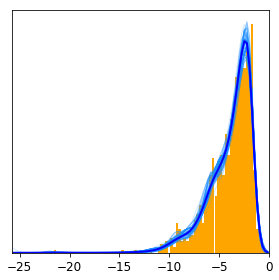

In [67]:
density = suftware.DensityEstimator(np.log(tau_given_bin['4']))
density.plot()

In [68]:
# 15156 0.5425835651212284
print(len(y_test), mutual_information)

10104 0.8145965723259211


Text(0.06,0.5,'Bin Number')

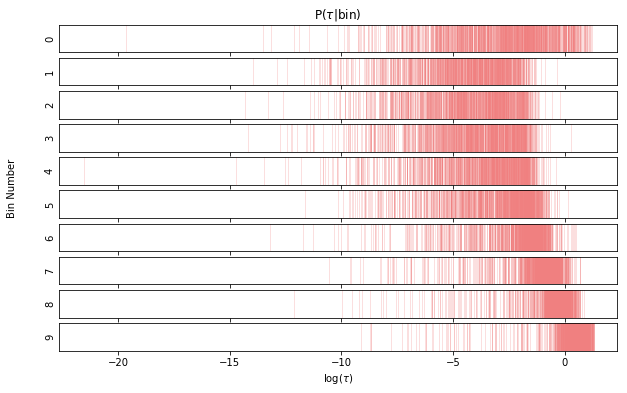

In [69]:
fig, ax = plt.subplots(nrows=bins,sharex=True, ncols=1,figsize=(10,6))   
ax[0].set_title(r'P($\tau$|bin)')

for bin_index in range(bins):

    for xc in np.log(tau_given_bin[str(bin_index)]):
        
        ax[bin_index].axvline(x=xc,alpha=0.25,linewidth=1,color='lightcoral')
        
    ax[bin_index].set_ylabel(str(bin_index))
    ax[bin_index].set_yticks([])
    
ax[bin_index].set_xlabel(r'$\log(\tau)$')    
fig.text(0.06, 0.5, 'Bin Number', ha='center', va='center', rotation='vertical')    
# plt.savefig('bin_vs_log_tau.pdf')

In [70]:
# for temp_index in range(10):

#     np.savetxt(str(temp_index)+'.txt',np.log(tau_given_bin[str(temp_index)]))

In [71]:
print(tf.__version__)
print(keras.__version__)

1.12.0
2.2.4


In [76]:
#model.save('best_model_ei_4p3_1500_epochs.h5')